# Introducing: HistFrames
HistFrames are similar to data frames, but each row corresponds to a bin, like in a histogram. They do not aim to be fully featured histogram objects like you might find in other libraries, however. Jack of all trades; master of... also all trades.

`HistFrame`s take a Binning object and an optional column name for the first column.

In [1]:
import pyNUISANCE as pn
hf = pn.HistFrame(pn.Binning.lin_space(0,10,50), "MCPrediction")
print(hf) #the printer only prints the first 20 rows by default

 ----------------------------
 | bin | MCPrediction | err |
 ----------------------------
 |   0 |            0 |   0 |
 |   1 |            0 |   0 |
 |   2 |            0 |   0 |
 |   3 |            0 |   0 |
 |   4 |            0 |   0 |
 |   5 |            0 |   0 |
 |   6 |            0 |   0 |
 |   7 |            0 |   0 |
 |   8 |            0 |   0 |
 |   9 |            0 |   0 |
 |  10 |            0 |   0 |
 |  11 |            0 |   0 |
 |  12 |            0 |   0 |
 |  13 |            0 |   0 |
 |  14 |            0 |   0 |
 |  15 |            0 |   0 |
 |  16 |            0 |   0 |
 |  17 |            0 |   0 |
 |  18 |            0 |   0 |
 |  19 |            0 |   0 |
 |  20 |            0 |   0 |
 |          ... | ... |
 ----------------------------


We can then add an entry to a bin

In [2]:
import pyProSelecta as pps

evs = pn.EventSource("dune_argon_sf_10mega.nuwro.pb.gz")
if not evs:
    print("Error: failed to open input file")

def enu_GeV(ev):
    bpart = pps.sel.Beam(ev,14)
    if not bpart:
        return pn.HistFrame.missing_datum
    return bpart.momentum().e() * 1E-3
    
hf.reset() # reset it so that repeated running of this cell doesn't keep filling the histo
ev, cvw = evs.first()
enu = enu_GeV(ev)
hf.fill(enu, cvw) # for correctly normalizable distributions that work for different generators 
                  # we *always* need to keep track of the weights, even if they're all '1' for 
                  # our testing generator
print(hf)

 ----------------------------
 | bin | MCPrediction | err |
 ----------------------------
 |   0 |            0 |   0 |
 |   1 |            0 |   0 |
 |   2 |            0 |   0 |
 |   3 |            0 |   0 |
 |   4 |            0 |   0 |
 |   5 |            0 |   0 |
 |   6 |            0 |   0 |
 |   7 |            0 |   0 |
 |   8 |            0 |   0 |
 |   9 |            0 |   0 |
 |  10 |            0 |   0 |
 |  11 |            1 |   1 |
 |  12 |            0 |   0 |
 |  13 |            0 |   0 |
 |  14 |            0 |   0 |
 |  15 |            0 |   0 |
 |  16 |            0 |   0 |
 |  17 |            0 |   0 |
 |  18 |            0 |   0 |
 |  19 |            0 |   0 |
 |  20 |            0 |   0 |
 |          ... | ... |
 ----------------------------


Lets make a more sensibly binned histogram and fill it with a few events

### Filling in a loop

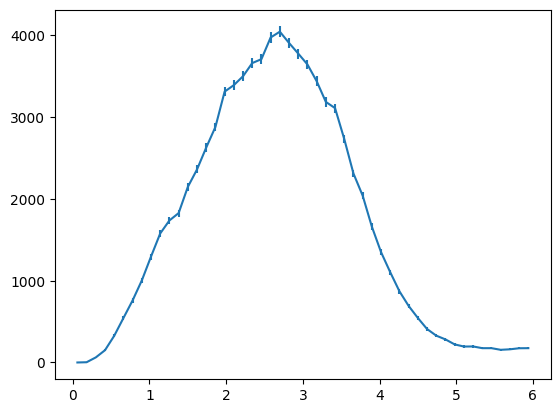

In [3]:
import matplotlib.pyplot as plt
import numpy as np

hf = pn.HistFrame(pn.Binning.lin_space(0,6,50, "E_{nu} [GeV]"), "mc")
for i, (ev, cvw) in enumerate(evs):
    hf.fill(enu_GeV(ev),cvw)
    if i >= 1E5:
        break

plt.errorbar(pn.Binning.get_bin_centers1D(hf.binning.bins),
             hf.sumweights[:,0],yerr=np.sqrt(hf.variances[:,0]))
plt.show()

### Filling directly from an EventFrame

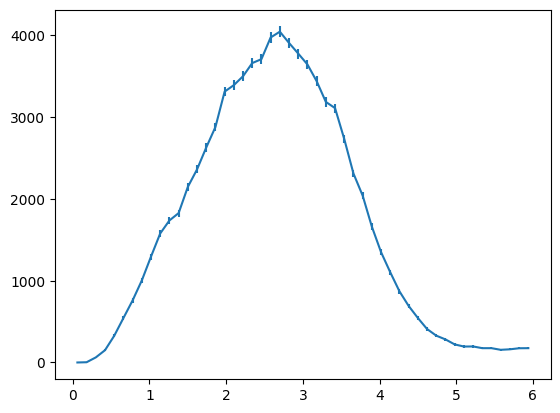

In [4]:
hf = pn.HistFrame(pn.Binning.lin_space(0,6,50, "E_{nu} [GeV]"), "mc")
fg = pn.EventFrameGen(evs,int(1E4)).limit(1E5).add_column("enu_GeV",enu_GeV)
batch = fg.first()

while batch.rows():
    hf.fill_from_EventFrame(batch,"enu_GeV")
    batch = fg.next()

plt.errorbar(pn.Binning.get_bin_centers1D(hf.binning.bins),
             hf.sumweights[:,0],yerr=np.sqrt(hf.variances[:,0]))
plt.show()

### Filling directly from an EventFrameGen

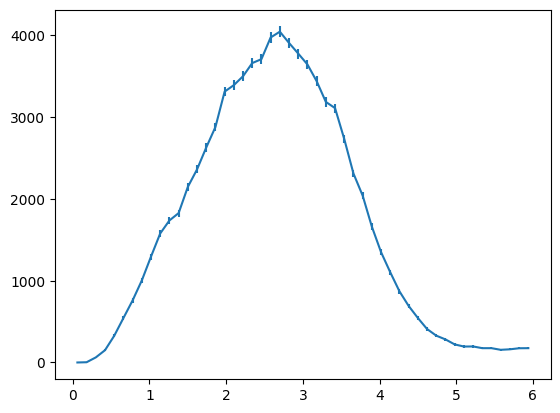

In [5]:
hf = pn.HistFrame(pn.Binning.lin_space(0,6,50, "E_{nu} [GeV]"), "mc")

fg = pn.EventFrameGen(evs,int(1E4)).limit(1E5).add_column("enu_GeV",enu_GeV)

hf.fill_from_EventFrameGen(fg,"enu_GeV")

plt.errorbar(pn.Binning.get_bin_centers1D(hf.binning.bins),
             hf.sumweights[:,0],yerr=np.sqrt(hf.variances[:,0]))
plt.show()

## 2D Histograms

As we saw in the [binning notebook](https://github.com/NUISANCEMC/eventinput/blob/main/notebooks/binning.ipynb), we can make multi-dimensional binnings. These can be used to instantiate `HistFrame`s.

In [ ]:
hf_ptpz = pn.HistFrame(pn.Binning.lin_spaceND([[0,5,75],[0,1.25,25]], ["pz","pt"]))

In [ ]:
def ptpz(ev):
    bpart = pps.sel.Beam(ev,14)
    if not bpart:
        return pn.Frame.missing_datum
    beam_pid = bpart.pid()
    cc_lep_pid = (beam_pid - 1) if (beam_pid > 0) else (beam_pid + 1);
    lep = pps.sel.OutPartHM(ev, int(cc_lep_pid))
    if not lep:
        return pn.Frame.missing_datum
    
    return [lep.momentum().pz() * 1E-3, lep.momentum().pt() * 1E-3]

In [ ]:
hf_ptpz.reset()
for i, (ev, cvw) in enumerate(evs):
    ev_ptpz = ptpz(ev)
    if ev_ptpz != pn.Frame.missing_datum:
        hf_ptpz.fill(ev_ptpz,cvw)
    if i >= 1E6:
        break

print(hf_ptpz)

Drawing a 2D histogram is a little more fiddly in matplotlib (or plotly for that matter)

From [numpy.histogram2d](https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html) and [matplotlib.pyplot.pcolormesh](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.pcolormesh.html):

```
(X[i+1, j], Y[i+1, j])       (X[i+1, j+1], Y[i+1, j+1])
                      ●╶───╴●
                      │     │
                      ●╶───╴●
    (X[i, j], Y[i, j])       (X[i, j+1], Y[i, j+1])
```

In [ ]:
nbins = len(hf_ptpz.binning.bins)
X = np.zeros((2*nbins,2))
Y = np.zeros((2*nbins,2))
C = np.zeros(((2*nbins)-1,1))
for i,bin in enumerate(hf_ptpz.binning.bins):
    X[2*i,0] = bin[0].low
    Y[2*i,0] = bin[1].low
    
    X[2*i + 1,0] = bin[0].low
    Y[2*i + 1,0] = bin[1].high
    
    X[2*i, 1] = bin[0].high
    Y[2*i, 1] = bin[1].low

    X[2*i + 1, 1] = bin[0].high
    Y[2*i + 1, 1] = bin[1].high

    C[2*i,0] = hf_ptpz.sumweights[i,0]
    if (2*i + 2) != (2*nbins):
        C[2*i + 1,0] = hf_ptpz.sumweights[i,0]
        
plt.pcolormesh(X, Y, C)
plt.show()

we provide a helper function for building the pcolormesh data structures following the above logic

In [ ]:
pcmdata = pn.convert.HistFrame.to_mpl_pcolormesh(hf_ptpz)
plt.pcolormesh(pcmdata["X"], pcmdata["Y"], pcmdata["C"])
plt.show()

## Projections
For rectangular binnings where projections onto lower dimensions are well defined, we can make histogram projections

In [ ]:
hf_pt = pn.HistFrame.project(hf_ptpz,1)
print(hf_pt.binning)
print(hf_pt)
print("nfills: %s" % hf_pt.nfills)

In [ ]:
plt.errorbar(pn.Binning.get_bin_centers1D(hf_pt.binning.bins),
             hf_pt.sumweights[:,0],yerr=np.sqrt(hf_pt.variances[:,0]))
plt.show()

While it is unlikely that we would want to continue calling fill on a projection histogram, it is supported.

In [ ]:
hf_pt.fill(0.5,10000)
print(hf_pt)
print("nfills: %s" % hf_pt.nfills)

In [ ]:
plt.errorbar(pn.Binning.get_bin_centers1D(hf_pt.binning.bins),
             hf_pt.sumweights[:,0],yerr=np.sqrt(hf_pt.variances[:,0]))
plt.show()